In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')

# Maths
import numpy as np
from numpy.random import default_rng

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ML
from soap import extract_species_pair_groups

from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Utilities
import h5py
import json
import itertools
from tempfile import mkdtemp
from shutil import rmtree
from copy import deepcopy
from tqdm.notebook import tqdm
import project_utils as utils
from tools import load_json, save_json

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
colorList = cosmostyle.color_cycle

# Load train and test splits

In [3]:
# Load SOAP cutoffs
soap_hyperparameters = load_json('../Processed_Data/soap_hyperparameters.json')   
cutoffs = soap_hyperparameters['interaction_cutoff']

In [4]:
# Load train sets for IZA and Deem
iza_train_idxs = np.loadtxt('../Processed_Data/IZA_230/svm_train.idxs', dtype=int)
iza_sort_idxs = np.argsort(iza_train_idxs)
iza_unsort_idxs = np.argsort(iza_sort_idxs)
deem_train_idxs = np.loadtxt('../Processed_Data/DEEM_330k/svm_train.idxs', dtype=int)

In [5]:
# Load cantons for IZA and Deem
iza_cantons = np.loadtxt('../Raw_Data/IZA_230/cantons.dat', usecols=1, dtype=int)
deem_cantons_2 = np.loadtxt('../Processed_Data/DEEM_330k/Data/cantons_2-class.dat', dtype=int)
deem_cantons_4 = np.loadtxt('../Processed_Data/DEEM_330k/Data/cantons_4-class.dat', dtype=int)

In [6]:
# Build set of "master" canton labels
cantons = {}

cantons[4] = np.concatenate((
    iza_cantons[iza_train_idxs], 
    deem_cantons_4[deem_train_idxs]
))

cantons[2] = np.concatenate((
    np.ones(len(iza_train_idxs), dtype=int),
    deem_cantons_2[deem_train_idxs]
))

# Build set of class weights (by sample) for centering and scaling
class_weights = {n_cantons: utils.balanced_class_weights(cantons[n_cantons]) for n_cantons in (2, 4)}

In [7]:
# Load dummy Deem cantons to test the "null" case
dummy_cantons = {}
dummy_cantons[2] = np.loadtxt('../Processed_Data/DEEM_330k/Data/dummy_cantons_2-class.dat', dtype=int)
dummy_cantons[2] = dummy_cantons[2][deem_train_idxs]
dummy_cantons[4] = np.loadtxt('../Processed_Data/DEEM_330k/Data/dummy_cantons_4-class.dat', dtype=int)
dummy_cantons[4] = dummy_cantons[4][deem_train_idxs]

# Build set of dummy class weights (by sample) for centering and scaling
dummy_class_weights = {n_cantons: utils.balanced_class_weights(dummy_cantons[n_cantons]) for n_cantons in (2, 4)}

# Model setup

In [8]:
model_dir = '../Processed_Data/Models'

deem_name = 'DEEM_330k'
iza_name = 'IZA_230'
deem_dir = f'../Processed_Data/{deem_name}/Data'
iza_dir = f'../Processed_Data/{iza_name}/Data'

In [9]:
# CV splits
n_splits = 2

# Template model parameters
svc_parameters = dict(
    penalty='l2',
    loss='squared_hinge',
    dual=False,
    multi_class='ovr',
    class_weight='balanced',
    tol=1.0E-3, # Consistent with kernel SVC
)

# Regularization parameters for cross-validation
C = np.logspace(-5, 5, 11)
parameter_grid = dict(svc__C=C)

# Linear SVC

In [10]:
# Linear model setup
n_species = 2
group_names = {'power': ['OO', 'OSi', 'SiSi', 
                         'OO+OSi', 'OO+SiSi', 'OSi+SiSi',
                         'OO+OSi+SiSi'], 
               'radial': ['O', 'Si', 'O+Si']}

## Optimize LinearSVC parameters

In [11]:
for cutoff in tqdm(cutoffs, desc='Cutoff', leave=True):
    work_dir = f'{model_dir}/{cutoff}/Linear_Models/LSVC'
    
    os.makedirs(work_dir, exist_ok=True)
    
    for spectrum_type in tqdm(('power', 'radial'), desc='Spectrum', leave=False):
        spectrum_name = spectrum_type.capitalize()
        
        # Load SOAPs
        iza_file = f'{iza_dir}/{cutoff}/soaps_{spectrum_type}_full_avg_nonorm.hdf5'
        iza_soaps = utils.load_hdf5(iza_file, indices=iza_train_idxs[iza_sort_idxs])
        iza_soaps = iza_soaps[iza_unsort_idxs]

        deem_file = f'{deem_dir}/{cutoff}/soaps_{spectrum_type}_full_avg_nonorm.hdf5'
        deem_soaps = utils.load_hdf5(deem_file, indices=deem_train_idxs)
        
        soaps = np.vstack((iza_soaps, deem_soaps))
        
        n_features = soaps.shape[1]
        feature_groups = extract_species_pair_groups(
            n_features, n_species, 
            spectrum_type=spectrum_type,
            combinations=True
        )
        
        for species_pairing, feature_idxs in zip(
            tqdm(group_names[spectrum_type], desc='Species', leave=False),
            feature_groups
        ):

            for n_cantons in tqdm((2, 4), desc='Classes', leave=False):
                
                cache_dir = mkdtemp()
                pipeline = Pipeline(
                    [
                        ('norm_scaler', utils.StandardNormScaler()),
                        ('svc', LinearSVC(**svc_parameters))
                    ],
                    memory=cache_dir
                )
                
                # IZA + DEEM classification
                gscv = GridSearchCV(
                    pipeline, parameter_grid,
                    scoring=[
                        'accuracy', 'balanced_accuracy',
                    ],
                    cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0),
                    refit=False, return_train_score=True, error_score='raise'
                )
                fit_params = {'norm_scaler__sample_weight': class_weights[n_cantons]}
                gscv.fit(soaps[:, feature_idxs], cantons[n_cantons], **fit_params)
                
                # Dummy DEEM classification
                dummy_gscv = GridSearchCV(
                    pipeline, parameter_grid,
                    scoring=[
                        'accuracy', 'balanced_accuracy',
                    ],
                    cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0),
                    refit=False, return_train_score=True, error_score='raise'
                )
                dummy_fit_params = {'norm_scaler__sample_weight': dummy_class_weights[n_cantons]}
                dummy_gscv.fit(deem_soaps[:, feature_idxs], dummy_cantons[n_cantons], **dummy_fit_params)
                
                # Prepare outputs
                output_dir = f'{n_cantons}-Class/{spectrum_name}/{species_pairing}'
                os.makedirs(f'{work_dir}/{output_dir}', exist_ok=True)
                
                save_json(gscv.cv_results_, f'{work_dir}/{output_dir}/cv_results.json', array_convert=True)
                save_json(dummy_gscv.cv_results_, f'{work_dir}/{output_dir}/dummy_cv_results.json', array_convert=True)
                rmtree(cache_dir)

KeyboardInterrupt: 

## Check the cross-validated parameters

In [ ]:
# IZA + DEEM classification
for cutoff in cutoffs:
    work_dir = f'{model_dir}/{cutoff}/Linear_Models/LSVC'
    for spectrum_type in ('power', 'radial'):
        spectrum_name = spectrum_type.capitalize()
        for group_name in group_names[spectrum_type]:
            for n_cantons in (2, 4):
                result_dir = f'{n_cantons}-Class/{spectrum_name}/{group_name}'
                cv_results = load_json(f'{work_dir}/{result_dir}/cv_results.json', array_convert=True)
                print(f'-----Optimal Parameters for {cutoff} {spectrum_type} {group_name} {n_cantons} -----')
                for score in ('accuracy', 'balanced_accuracy'):
                    idx = np.argmin(cv_results[f'rank_test_{score}'])
                    opt_parameters = utils.get_optimal_parameters(cv_results, score, **svc_parameters)
                    print(f'{score} =', cv_results[f'mean_test_{score}'][idx])
                    print(opt_parameters)
                    print('')
                    
                    save_json(opt_parameters, f'{work_dir}/{output_dir}/svc_parameters_{score}.json')

In [ ]:
# Dummy DEEM model
for cutoff in cutoffs:
    work_dir = f'{model_dir}/{cutoff}/Linear_Models/LSVC'
    for spectrum_type in ('power', 'radial'):
        spectrum_name = spectrum_type.capitalize()
        for group_name in group_names[spectrum_type]:
            for n_cantons in (2, 4):
                result_dir = f'{n_cantons}-Class/{spectrum_name}/{group_name}'
                cv_results = load_json(f'{work_dir}/{result_dir}/cv_results_dummy.json', array_convert=True)
                print(f'-----Optimal Parameters for {cutoff} {spectrum_type} {group_name} {n_cantons} -----')
                for score in ('accuracy', 'balanced_accuracy'):
                    idx = np.argmin(cv_results[f'rank_test_{score}'])
                    opt_parameters = utils.get_optimal_parameters(cv_results, score, **svc_parameters)
                    print(f'{score} =', cv_results[f'mean_test_{score}'][idx])
                    print(opt_parameters)
                    print('')
                    
                    save_json(opt_parameters, f'{work_dir}/{output_dir}/dummy_svc_parameters_{score}.json')

In [ ]:
### BEGIN TMP

In [12]:
# Load SOAPs
iza_file = f'{iza_dir}/6.0/soaps_power_full_avg_nonorm.hdf5'
idxs_sort = np.argsort(iza_train_idxs)
idxs_rev = np.argsort(idxs_sort)
iza_soaps = utils.load_hdf5(iza_file, indices=iza_train_idxs[idxs_sort])
iza_soaps = iza_soaps[idxs_rev]
n_iza_soaps = iza_soaps.shape[0]
n_train_iza = n_iza_soaps // 2
n_test_iza = n_iza_soaps - n_train_iza

deem_file = f'{deem_dir}/6.0/soaps_power_full_avg_nonorm.hdf5'
deem_soaps = utils.load_hdf5(deem_file, indices=deem_train_idxs)
n_deem_soaps = deem_soaps.shape[0]
n_train_deem = n_deem_soaps // 2
n_test_deem = n_deem_soaps - n_train_deem

deem_idxs = np.arange(0, n_deem_soaps)
np.random.shuffle(deem_idxs)
deem_train_idxs2, deem_test_idxs2 = np.split(deem_idxs, [n_train_deem])

iza_idxs = np.arange(0, n_iza_soaps)
np.random.shuffle(iza_idxs)
iza_train_idxs2, iza_test_idxs2 = np.split(iza_idxs, [n_train_iza])

train_soaps = np.vstack((iza_soaps[iza_train_idxs2], deem_soaps[deem_train_idxs2]))
test_soaps = np.vstack((iza_soaps[iza_test_idxs2], deem_soaps[deem_test_idxs2]))

train_cantons = np.concatenate((
    np.ones(n_train_iza, dtype=int),
    np.ones(n_train_deem, dtype=int) * 2
))

test_cantons = np.concatenate((
    np.ones(n_test_iza, dtype=int),
    np.ones(n_test_deem, dtype=int) * 2
))

class_weights = utils.balanced_class_weights(train_cantons)

In [13]:
class_weights

array([0.00877193, 0.00877193, 0.00877193, ..., 0.00010002, 0.00010002,
       0.00010002])

In [14]:
print(train_soaps)
print(np.amin(train_soaps), np.amax(train_soaps))

[[2.35997622e-07 4.04989320e-10 6.89775943e-10 ... 2.57261335e-06
  1.84480447e-06 5.63119002e-07]
 [2.30559450e-07 3.72512315e-10 4.11354302e-10 ... 1.81132566e-06
  1.76705071e-06 1.88533917e-06]
 [2.23621477e-07 2.69800274e-10 8.55570248e-10 ... 1.66902117e-06
  2.49053018e-06 1.67068613e-06]
 ...
 [2.37662126e-07 3.69579529e-10 8.26178296e-10 ... 1.66802165e-06
  1.19704324e-06 2.07366366e-06]
 [2.35354079e-07 8.87149705e-10 1.14386965e-09 ... 1.02918237e-06
  1.44683605e-06 1.04780986e-06]
 [2.31789853e-07 6.28000351e-10 6.05584442e-10 ... 1.98545926e-06
  1.36426216e-06 1.19382544e-06]]
-7.625279659094262e-05 0.0004666038134109295


In [15]:
ns = utils.StandardNormScaler(norm_type='std')
ns.fit(train_soaps, sample_weight=class_weights)
ttrain_soaps = ns.transform(train_soaps)
ttest_soaps = ns.transform(test_soaps)

In [16]:
print(ttrain_soaps)
print(np.amin(ttrain_soaps), np.amax(ttrain_soaps))

[[ 2.80722391e-05 -3.99609991e-07 -1.23319702e-06 ...  3.86250440e-03
   1.81210038e-04 -4.41428066e-03]
 [ 4.32287512e-06 -5.41442242e-07 -2.44910866e-06 ...  5.37839853e-04
  -1.58353001e-04  1.36006534e-03]
 [-2.59763581e-05 -9.90002083e-07 -5.09146891e-07 ... -8.36265236e-05
   3.00119704e-03  4.22641350e-04]
 ...
 [ 3.53413924e-05 -5.54250189e-07 -6.37506226e-07 ... -8.79915938e-05
  -2.64766641e-03  2.18250839e-03]
 [ 2.52617840e-05  1.70606118e-06  7.49902501e-07 ... -2.87790445e-03
  -1.55678141e-03 -2.29755852e-03]
 [ 9.69623891e-06  5.74314692e-07 -1.60087471e-06 ...  1.29830901e-03
  -1.91739473e-03 -1.65988521e-03]]
-0.6572693118216072 1.0794660530461788


In [17]:
import matplotlib.pyplot as plt

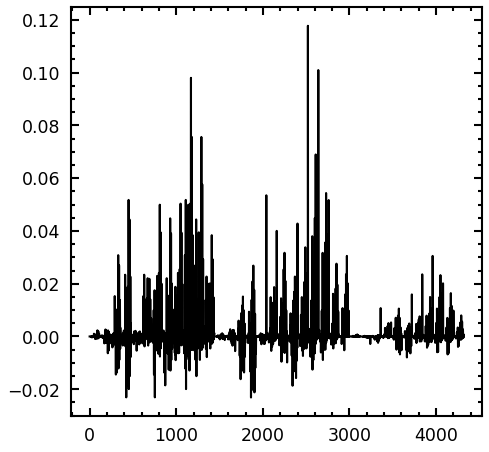

In [18]:
plt.plot(np.mean(ttrain_soaps, axis=0))
plt.show()

In [19]:
np.average(ttrain_soaps, weights=class_weights, axis=0)

array([-1.86156728e-18,  4.31691345e-22, -9.95576491e-21, ...,
        4.09887184e-18,  1.18079834e-17, -5.35499523e-18])

In [20]:
np.trace(np.cov(ttrain_soaps, aweights=class_weights, rowvar=False, bias=True))

1.0

In [21]:
np.trace((np.sqrt(class_weights)[:, np.newaxis] * ttrain_soaps).T @ (np.sqrt(class_weights)[:, np.newaxis] * ttrain_soaps))

0.9999999999999997

In [22]:
ns = utils.StandardNormScaler(norm_type='norm')
ns.fit(train_soaps, sample_weight=class_weights)
ttrain_soaps = ns.transform(train_soaps)
ttest_soaps = ns.transform(test_soaps)

In [23]:
print(ttrain_soaps)
print(np.amin(ttrain_soaps), np.amax(ttrain_soaps))

[[ 2.81920463e-05 -4.01315453e-07 -1.23846008e-06 ...  3.87898886e-03
   1.81983409e-04 -4.43312001e-03]
 [ 4.34132436e-06 -5.43753019e-07 -2.45956101e-06 ...  5.40135255e-04
  -1.59028823e-04  1.36586985e-03]
 [-2.60872205e-05 -9.94227231e-07 -5.11319837e-07 ... -8.39834263e-05
   3.01400560e-03  4.24445105e-04]
 ...
 [ 3.54922230e-05 -5.56615627e-07 -6.40226986e-07 ... -8.83671259e-05
  -2.65896617e-03  2.19182293e-03]
 [ 2.53695966e-05  1.71334234e-06  7.53102948e-07 ... -2.89018682e-03
  -1.56342547e-03 -2.30736408e-03]
 [ 9.73762068e-06  5.76765762e-07 -1.60770695e-06 ...  1.30384996e-03
  -1.92557782e-03 -1.66696930e-03]]
-0.6600744168915281 1.0840730164989762


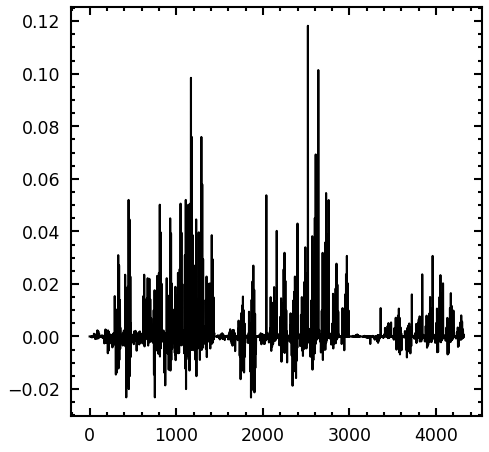

In [24]:
plt.plot(np.mean(ttrain_soaps, axis=0))
plt.show()

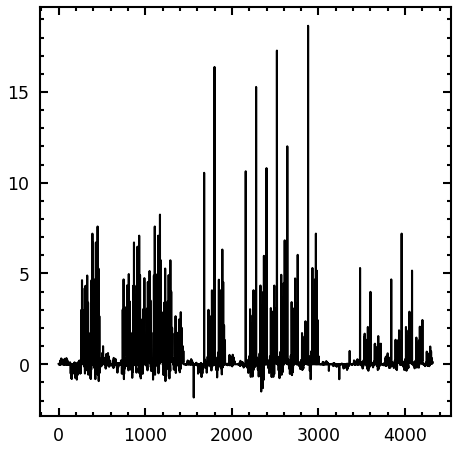

In [25]:
plt.plot(np.mean(train_soaps / np.std(train_soaps), axis=0))
plt.show()

In [26]:
np.average(ttrain_soaps, weights=class_weights, axis=0)

array([-1.86706555e-18, -2.21606856e-22, -1.09934371e-20, ...,
        3.51415441e-18,  1.16522352e-17, -3.84362376e-18])

In [27]:
np.trace(ttrain_soaps @ ttrain_soaps.T)

5056.000000000002

In [33]:
len(ttrain_soaps)

5056

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

In [29]:
%%timeit
svc = LinearSVC(C=1.0, loss='hinge', dual=True, multi_class='ovr', class_weight='balanced', tol=1.0E-3)
svc.fit(ttrain_soaps, train_cantons)
#print(confusion_matrix(test_cantons, svc.predict(ttest_soaps)))
#print(balanced_accuracy_score(test_cantons, svc.predict(ttest_soaps)))

/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/sklearn/svm/_base.py:947: C

959 ms ± 24.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [30]:
%%timeit
svc = LinearSVC(C=1.0, loss='squared_hinge', dual=False, multi_class='ovr', class_weight='balanced', tol=1.0E-3)
svc.fit(ttrain_soaps, train_cantons)
#print(confusion_matrix(test_cantons, svc.predict(ttest_soaps)))
#print(balanced_accuracy_score(test_cantons, svc.predict(ttest_soaps)))

1.91 s ± 902 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
%%timeit
svc = SVC(C=1.0, kernel='linear', decision_function_shape='ovr', class_weight='balanced', tol=1.0E-3)
svc.fit(ttrain_soaps, train_cantons)
#print(confusion_matrix(test_cantons, svc.predict(ttest_soaps)))
#print(balanced_accuracy_score(test_cantons, svc.predict(ttest_soaps)))

12.2 s ± 17.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%%timeit
K_train = ttrain_soaps @ ttrain_soaps.T
K_test = ttest_soaps @ ttrain_soaps.T
svc = SVC(C=1.0, kernel='precomputed', decision_function_shape='ovr', class_weight='balanced', tol=1.0E-3)
svc.fit(K_train, train_cantons)
#print(confusion_matrix(test_cantons, svc.predict(K_test)))
#print(balanced_accuracy_score(test_cantons, svc.predict(K_test)))

2.45 s ± 24.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
class_weights

In [ ]:
### END TMP